In [3]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip flickr8k.zip -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/Images/2846037553_1a1de50709.jpg  
  inflating: /content/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/Images/2846843520_b0e6211478.jpg  
  inflating: /content/Images/2847514745_9a35493023.jpg  
  inflating: /content/Images/2847615962_c330bded6e.jpg  
  inflating: /content/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/Images/2848266893_9693c66275.jpg  
  inflating: /content/Images/2848571082_26454cb981.jpg  
  inflating: /content/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/Images/2848977044_446a31d86e.jpg  
  inflating: /content/Images/2849194983_2968c72832.jpg  
  inflating: /content/Images/28507194

In [5]:
import pickle
import os
import tqdm
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import  Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [6]:
model = VGG16()
model = Model(model.inputs, model.layers[-2].output)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
BASE_DIR = '/content'

In [12]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')
for img_name in tqdm.tqdm(os.listdir(directory)):
    img_path = directory + '/'+img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose = 0)
    image_id = img_name.split('.')[0]
    features[image_id] = features


  0%|          | 0/8091 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
100%|██████████| 8091/8091 [12:44<00:00, 10.58it/s]


In [13]:
WORKING_DIR = "/models"

In [19]:
with open('features.pkl', 'wb') as f:
  pickle.dump(features, f)

In [20]:
with open('features.pkl', 'rb') as f:
  features = pickle.load(f)

In [23]:
from google.colab import files
files.download('features.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()


In [25]:
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [52]:
mapping= {}
for line in tqdm.tqdm(captions_doc.split('\n')):
  tokens = line.split(',')
  if(len(line)<2):
    continue
  image_id, caption = tokens[0], tokens[1:]
  image_id = image_id.split('.')[0]
  caption = " ".join(caption)
  if image_id not in mapping:
    mapping[image_id] = []

  mapping[image_id].append(caption)


100%|██████████| 40456/40456 [00:00<00:00, 796765.52it/s]


In [53]:
mapping

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [54]:
len(mapping)

8091

In [55]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):

      caption = captions[i]
      caption = caption.lower()
      caption = caption.replace('[^A-Za-z]', '')
      caption = caption.replace('\s+', ' ')
      caption = '<start> ' + " ".join([word for word in caption.split() if len(word)>1]) + ' <end>'
      captions[i] = caption

In [56]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [57]:
clean(mapping)

In [58]:
mapping['1000268201_693b08cb0e']

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [59]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [60]:
len(all_captions)

40455

In [62]:
all_captions[:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [63]:
tokenizer = Tokenizer()

In [64]:
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [65]:
vocab_size

8483

In [66]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [67]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.9)
train = image_ids[:split]
test = image_ids[split:]

In [68]:
len(train)

7281

In [69]:
def data_gen(data_keys, mapping, features, tokenizer, vocab_size, batch_size):
  X1, X2, y= list(), list(), list()
  n = 0
  while 1:
    for keys in data_keys:
      n+=1
      captions = mapping[key]
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]

        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]


          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
    if n == batch_size:
      X1, X2, y = np.array(X1), np.array(X2), np.array(y)
      yield [X1, X2], y
      X1, X2, y= list(), list(), list()
      n = 0


In [71]:
#encoder model
inputs1 = Input(shape=(4096, 1))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape = (max_length,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)



In [72]:
## decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

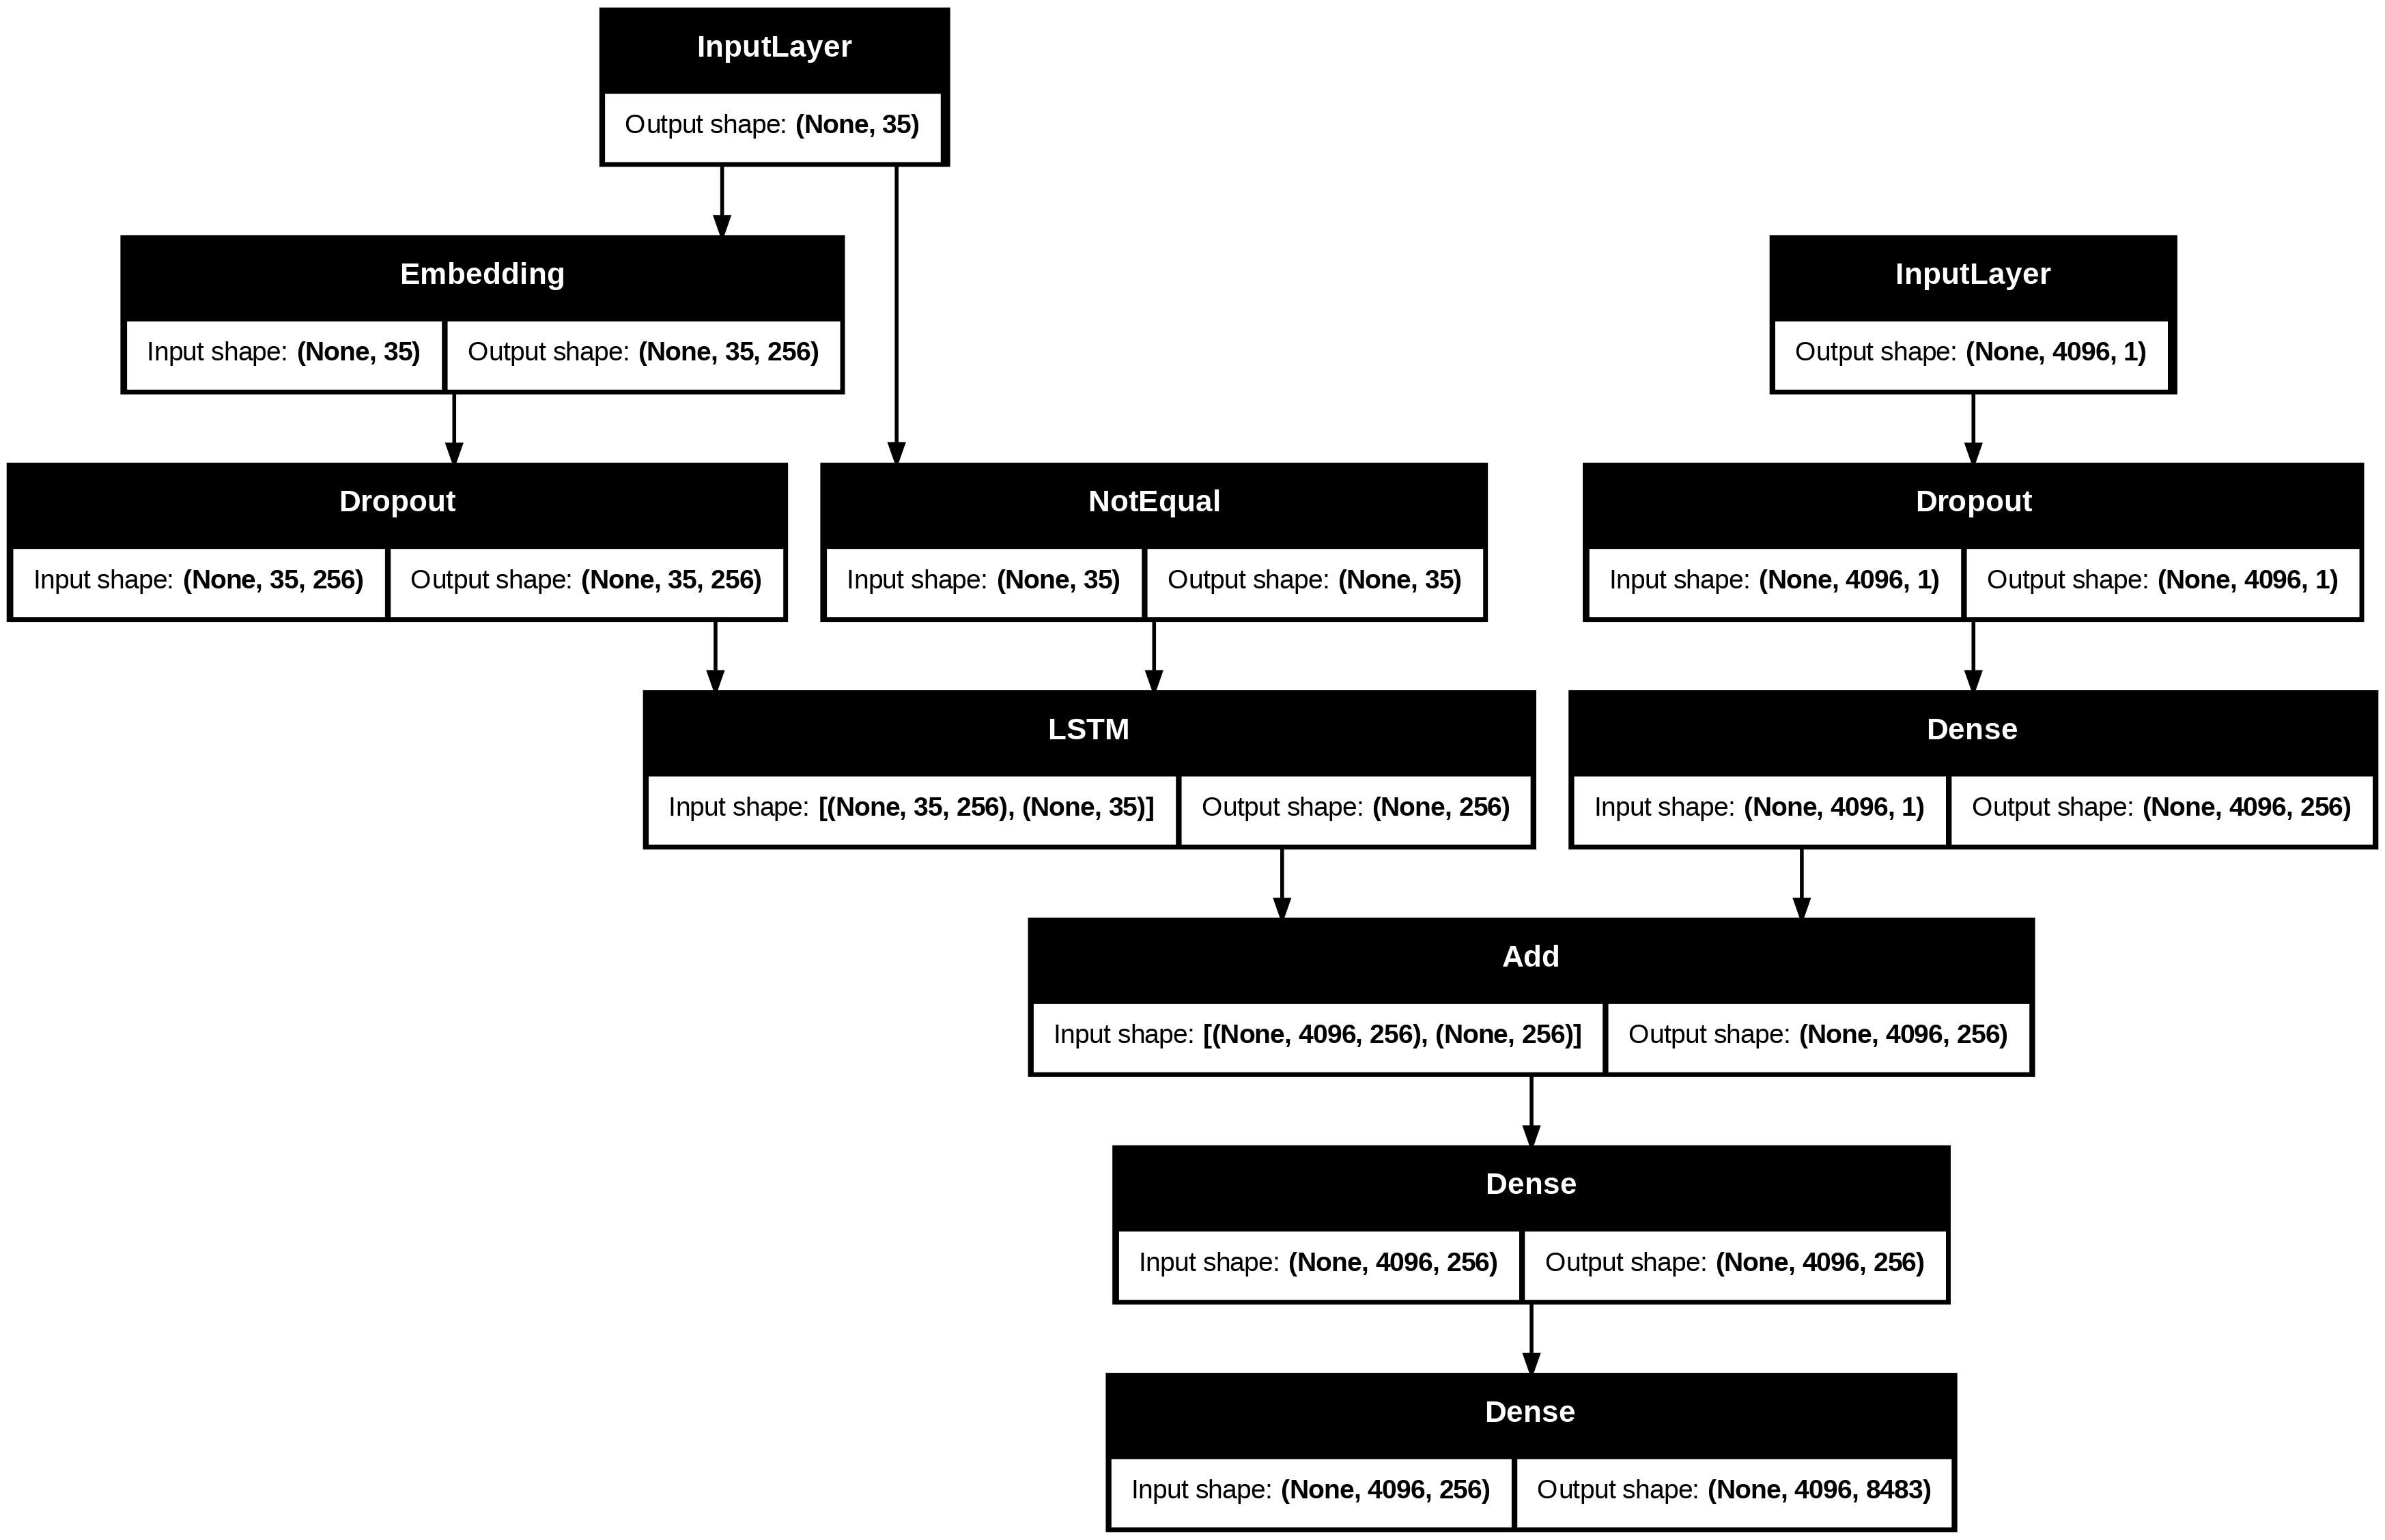

In [76]:
from tensorflow.keras.utils import plot_model
model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

plot_model(model, show_shapes = True)

In [ ]:
#training
epochs = 15
batch_size = 64
steps = len(train)//batch_size
for i in range(epochs):
  generator = data_gen(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose = 1)